# TD 6 - 10th of Feb. 2023

Faisal Jayousi: jayousi@unice.fr


In [1]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.linalg import norm

## Forward model: the blurring operator

In SMLM type data, the acquisition consist of a blurred and noisy image of a molecule sample (the ground truth image).
Let $x\in\mathbb R^n$ be the ground truth image.
The microscope only allows us to have access to a blurred and noisy version $$y=Ax+\eta,$$
where $A:\mathbb R^n \longrightarrow \mathbb R^n$ is the forward blurring operator and $\eta\in\mathbb R^n$ is a Gaussian distributed noisy vector with $0$ mean and variance $\sigma^2$: $\eta\sim\mathcal N(0,\sigma^2)$.

Given the acquisition $y$, we aim to reconstruct the ground truth $x$. To do so, we need to understand how the microscope works and propose a forward model accordingly.

Load the ground truth image.


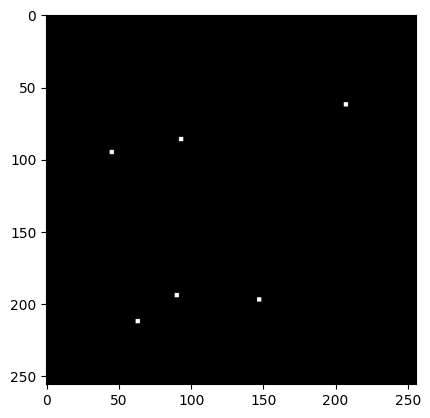

In [3]:
# load the image
gt = np.float64(plt.imread("gt.png"))
gt = gt[:, :, 1]
gt = gt * 255.0

# plot the image
plt.imshow(gt, cmap="gray")
plt.show()


We will now focus on the blurring operator. Recall that it is inconvenient (and often impossible) to construct the matrix $A$.


In [4]:
n = np.shape(gt)[0]
print("The ground truth image has dimensions " + str(n) + "*" + str(n))
print("It is a vector of lenght " + str(n * n))
print("The matrix A has dimensions " + str(n * n) + "*" + str(n * n))


The ground truth image has dimensions 256*256
It is a vector of lenght 65536
The matrix A has dimensions 65536*65536


Multiplying an image with a blurring matrix (huge) can be written as a convolution between the image itself and an appropriate kernel (that has the same size as the image), called Point Spread Function (PSF), since it describes how a point is distorted (and spread) by the microscope. To do so, the Fast Fourier Trasform is used and only the PSF has to be stored.


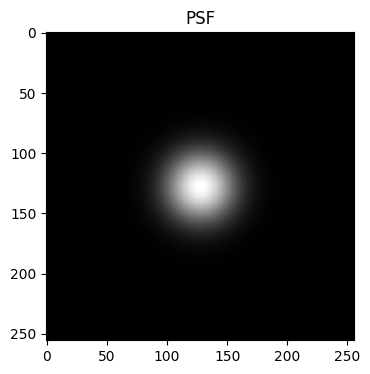

In [5]:
# convolution kernel: the point spread function PSF
s = 20
n = np.shape(gt)[0]
x = np.concatenate((np.arange(0, n / 2), np.arange(-n / 2, 0)))
[Y, X] = np.meshgrid(x, x)
h = np.exp((-(X**2) - Y**2) / (2 * s**2))
h = h / np.sum(h)

plt.figure(figsize=(4, 4))
plt.imshow(np.fft.fftshift(h), cmap="gray")
plt.title("PSF")
plt.show()


In [6]:
# define the forward operator as convolution with h
def forward_operator(x, h):
  return np.real(np.fft.ifft2(np.fft.fft2(h) * np.fft.fft2(x)))


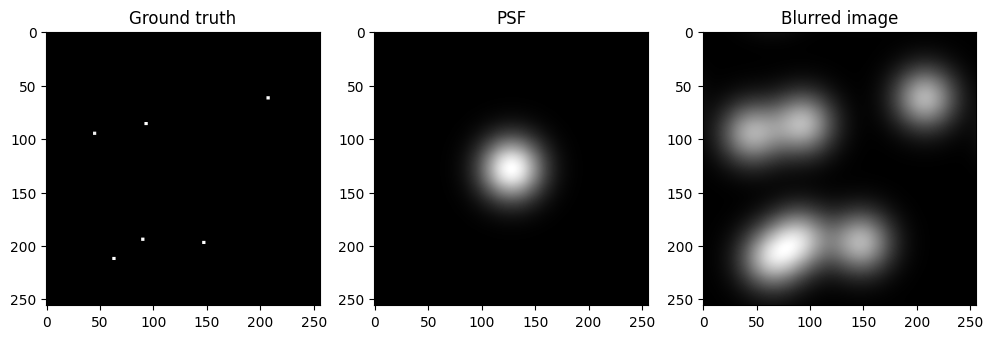

In [7]:
# compute the blurred imaage
blurred_image = forward_operator(gt, h)

# plot the ground truth, the PSF and the blurred image
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(gt, cmap="gray")
plt.title("Ground truth")
plt.subplot(1, 3, 2)
plt.imshow(np.fft.fftshift(h), cmap="gray")
plt.title("PSF")
plt.subplot(1, 3, 3)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred image")
plt.show()


Now we need to generate a noisy realisation of the blurred image in order to obtain a realistic acquisition.

We have two options:

1. add Gaussian noise to the blurred image


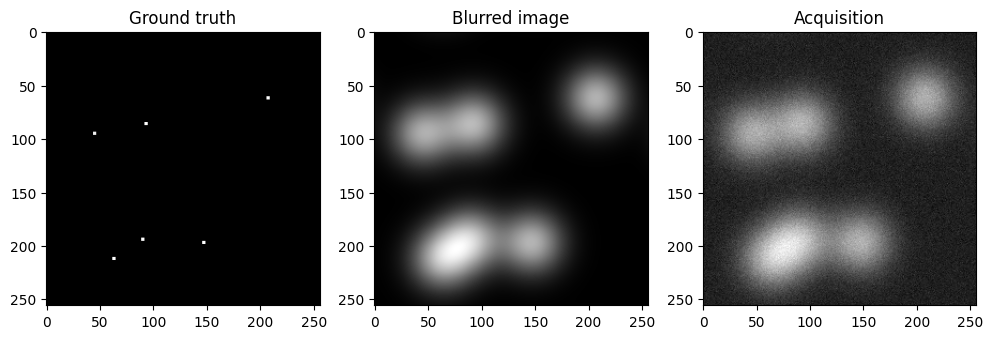

In [8]:
# in this way you will have a deterministic result
np.random.seed(24)
# generate gaussian noise
sigma_noise = 0.05
noise = sigma_noise * np.random.randn(n, n)
# add gaussian noise to the blurred image
acq = blurred_image + noise

# plot the ground truth, the blurred image and the final acquisition (blurred and noisy)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(gt, cmap="gray")
plt.title("Ground truth")
plt.subplot(1, 3, 2)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred image")
plt.subplot(1, 3, 3)
plt.imshow(acq, cmap="gray")
plt.title("Acquisition")
plt.show()


2. generate a Poisson noise realisation of the blurred image (the noise it is not added and its intensity depend on the signal itself!). it is more realistic but more difficult to consider from a mathematical point of view. In the following we will use the Gaussian noise for simplicity.


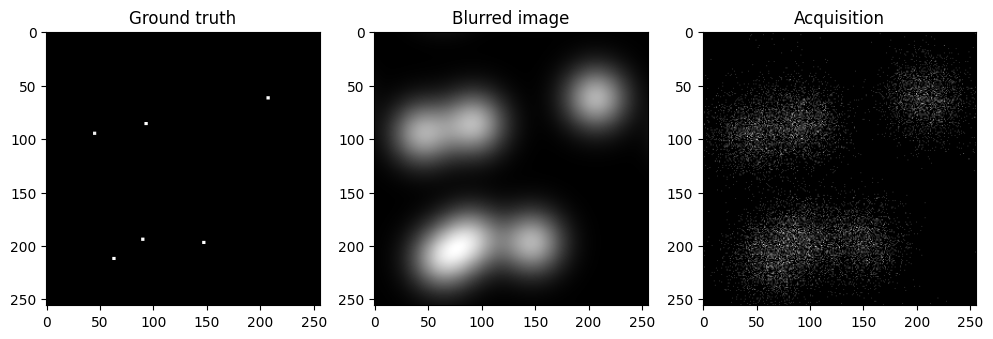

In [9]:
acq_p = np.random.poisson(blurred_image)

# plot the ground truth, the blurred image and the final acquisition (blurred and noisy)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(gt, cmap="gray")
plt.title("Ground truth")
plt.subplot(1, 3, 2)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred image")
plt.subplot(1, 3, 3)
plt.imshow(acq_p, cmap="gray")
plt.title("Acquisition")
plt.show()


## Implementation of the Forward-Backward algorithm (ISTA)


Let $y\in\mathbb R^n$ be a noisy acquisition and $A:\mathbb R^n \longrightarrow \mathbb R^n$ the blurring operator. To solve the inverse problem i.e. to find $x\in\mathbb R^n$ such that $$y=Ax+\eta$$, we use a variational approach and solve
$$ \operatorname{argmin}_{x\in\mathbb R^n} \frac{1}{2}\|Ax-y\|\_2^2+\lambda \|x\|\_1+\texttt{i}_{\ge 0}(x) $$
with the Forward-Backward algorithm.

The first step of FB algorithm is the forward step: a gradient descent step for the smooth function $f$.

Implement a function that computes the gradient of $f$, $\nabla f(x)= A^t (Ax-y)$.


In [10]:
# define the gradient of the fidelity term in terms of convolutions
def gradient(x, h, y):
  aus = forward_operator(x, h) - y
  return np.real(np.fft.ifft2(np.conj(np.fft.fft2(h)) * np.fft.fft2(aus)))


Compute now the Lipschitz constant of $\nabla f$, recalling that $L=\|A\|^2$. This will be needed for choosing a suitable stepsize.


In [11]:
# compute the Lipschitz constant Lips
hF = np.real(np.fft.fft2(np.fft.fftshift(h)))
Lips = np.max(hF**2)


Go to TD 5 and copy here the code of the soft thresholding function. You need it to define the backward step in terms of the peanlty $g(x)=\|x\|_1$.


In [12]:
# prox of \ell_1 norm: soft thresholding function
def soft_thresholding(x, gamma):
  return np.sign(x) * np.maximum(0, np.abs(x) - gamma)


Implement a function that computes the fidelity term $f(x)=\frac{1}{2}\|Ax-y\|_2^2$ and the cost function $F(x)=\frac{1}{2}\|Ax-y\|_2^2+\lambda \|x\|_1$ at each point.


In [13]:
# fidelity
def fidelity(x, h, y):
  return 0.5 * np.linalg.norm(forward_operator(x, h) - y) ** 2


# cost function
def cost_function(x, h, y, lmbda):
  return fidelity(x, h, y) + lmbda * np.linalg.norm(x, 1)


You have now the elements to define the function for the FB algorithm.


In [14]:
# input parameters
# x0 is the initialisation
# tau is the stepsize
# lambda is the regolarisation parameter
# y is the acquisition, h is the psf ---> needed to compute the gradient of f at each iteration
# epsilon is the tolerance parameter, maxiter is the maximum numer of iterations ---> needed for the stopping criterion


def FB(x0, tau, lmbda, y, h, epsilon, maxiter):
  xk = x0
  cost = np.zeros(maxiter)
  norms = np.zeros(maxiter)

  for k in np.arange(maxiter):

    if (k + 1) % 100 == 0:
      print(f"Iter {k+1}/{maxiter}")
    # forward step: gradient descent of f
    xkk = xk - tau * gradient(xk, h, y)

    # backward step
    xkk = soft_thresholding(xkk, tau * lmbda)

    # positivity constraints
    xkk = np.maximum(0, xkk)

    # compute the cost function
    cost[k] = cost_function(xkk, h, y, lmbda)
    norms[k] = np.linalg.norm(xkk - xk, "fro")

    # update the iteration
    xk = xkk
    if np.abs(cost[k] - cost[k - 1]) / cost[k] < epsilon:
      break
  return xk, cost, norms


Useful: define a function to plot reconstruction, cost function and relative changes of the iterates.


In [15]:
def plot_results(rec, cost, norms):
  # plot the ground truth, the final acquisition (blurred and noisy) and the reconstruction
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 3, 1)
  plt.imshow(gt, cmap="gray")
  plt.title("Ground truth")
  plt.subplot(1, 3, 2)
  plt.imshow(acq, cmap="gray")
  plt.title("Acquisition")
  plt.subplot(1, 3, 3)
  plt.imshow(rec, cmap="gray")
  plt.title("Reconstruction")
  plt.show()

  # plot how the cost function decreases and how the iterates converge
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(cost)
  plt.xlabel("$k$")
  plt.ylabel("$F(x_k)$")
  plt.title("Cost function")
  plt.subplot(1, 2, 2)
  plt.plot(norms)
  plt.xlabel("$k$")
  plt.ylabel("$||x^{(k+1)}-x_{k}||$")
  plt.title("Relative difference in the reconstructions")
  plt.show()


Check that your algorithm is working by computing the reconstruction for the following set of input parameters.


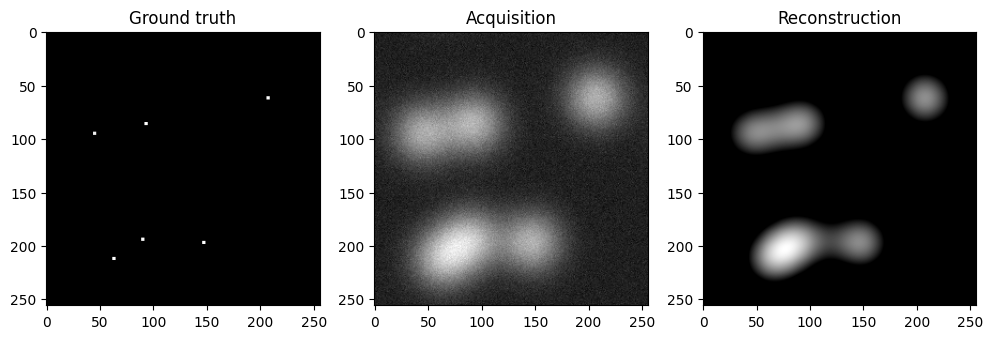

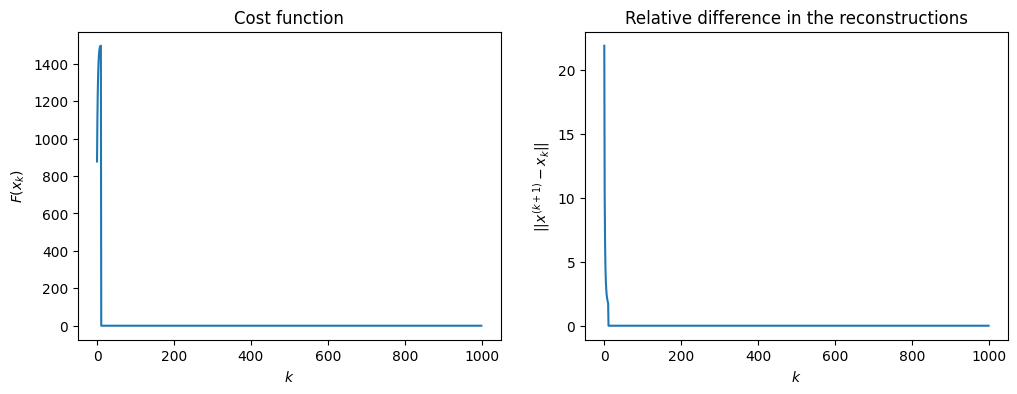

In [16]:
dim = (n, n)
# x0 = np.zeros(dim)
x0 = blurred_image
tau = 0.5
lmbda = 0.3
maxiter = 1000
epsilon = 0.001

# compute the reconstruction
rec, cost, norms = FB(x0, tau, lmbda, acq, h, epsilon, maxiter)
plot_results(rec, cost, norms)


## Questions: regularisation parameter


1. Try different values of the regularisation parameter and see what happens. Can you explain the behaviour of the reconstructions with respect to $\lambda$? Does the choice of $\lambda$ affect the reconstruction?


\lambda=0.001
Iter 100/800
Iter 200/800
Iter 300/800
Iter 400/800
Iter 500/800
Iter 600/800
Iter 700/800
Iter 800/800


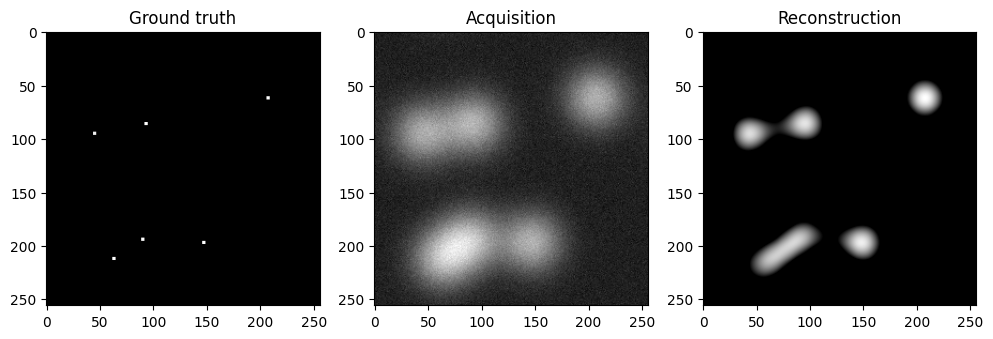

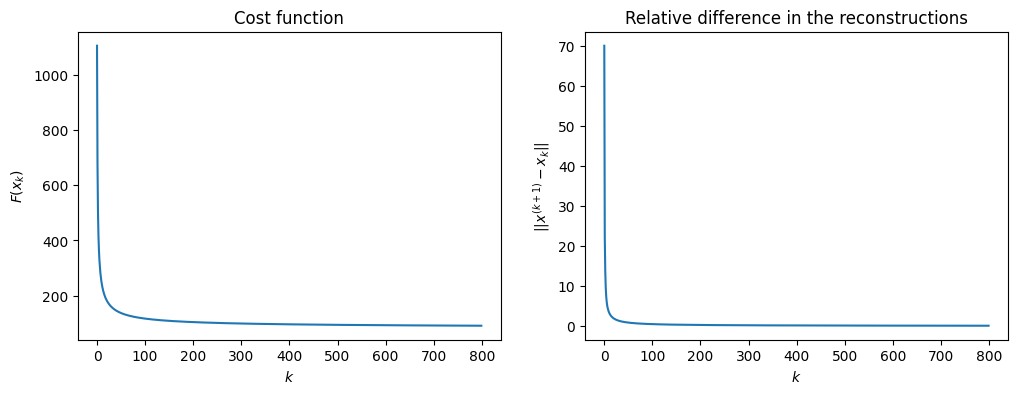

\lambda=0.1
Iter 100/800
Iter 200/800
Iter 300/800
Iter 400/800
Iter 500/800
Iter 600/800
Iter 700/800
Iter 800/800


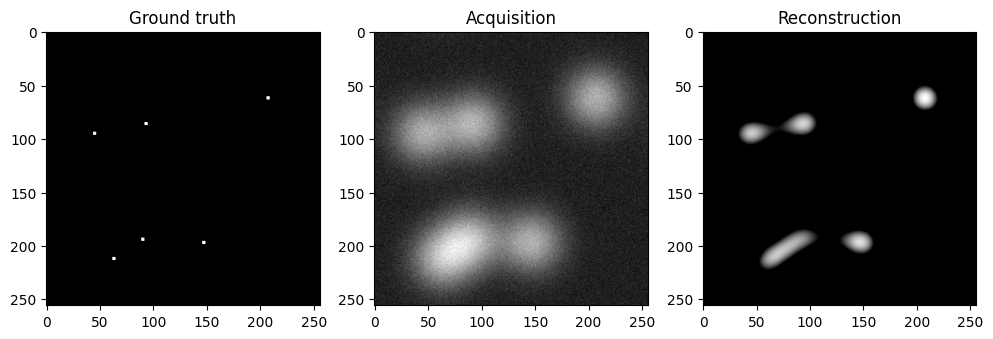

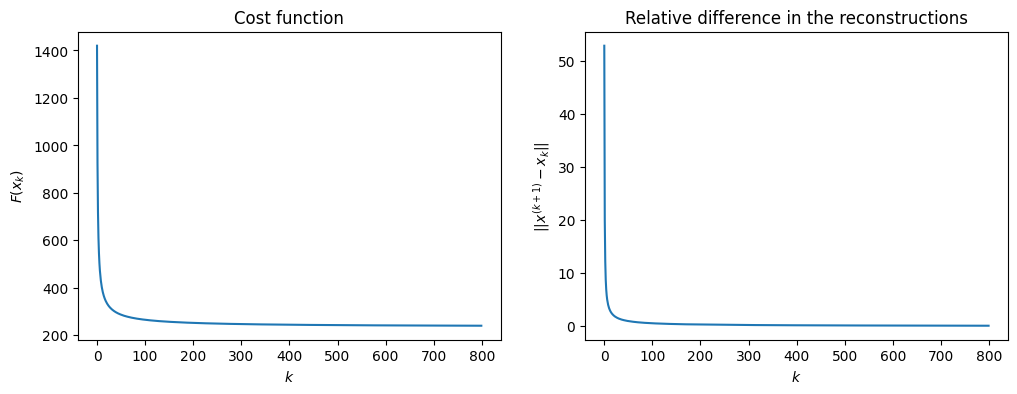

\lambda=0.2
Iter 100/800
Iter 200/800
Iter 300/800
Iter 400/800
Iter 500/800
Iter 600/800
Iter 700/800
Iter 800/800


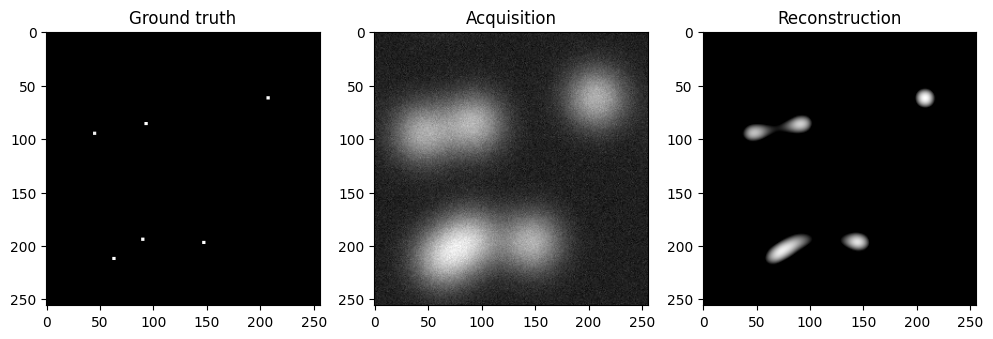

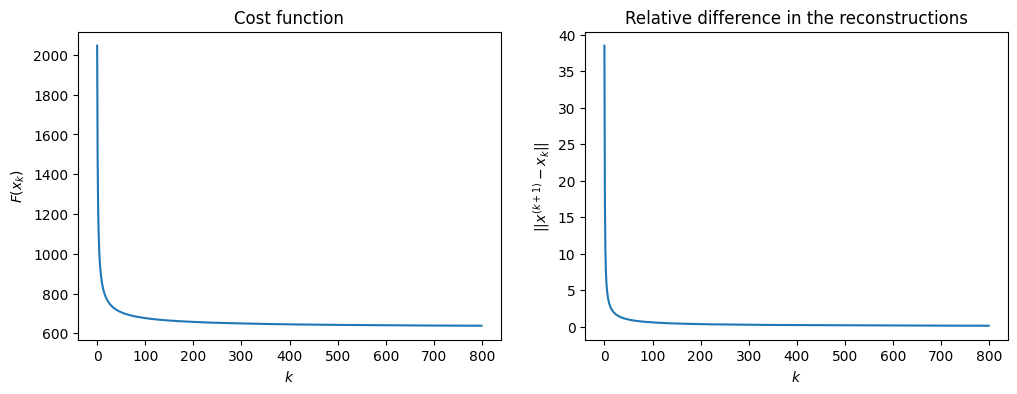

\lambda=0.5
Iter 100/800
Iter 200/800
Iter 300/800
Iter 400/800
Iter 500/800
Iter 600/800
Iter 700/800
Iter 800/800


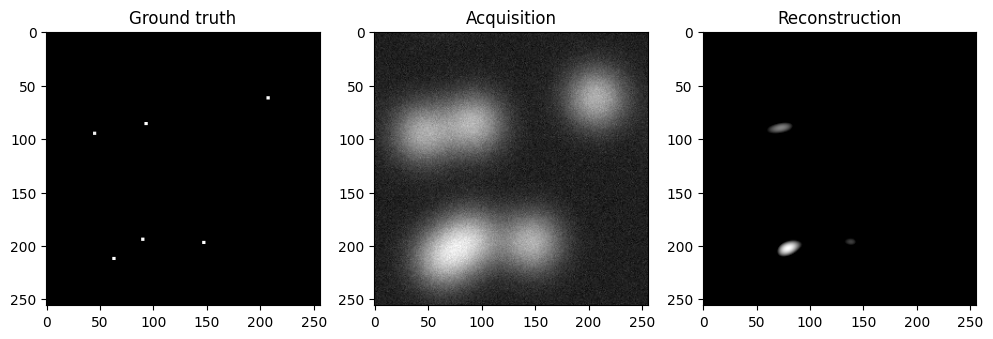

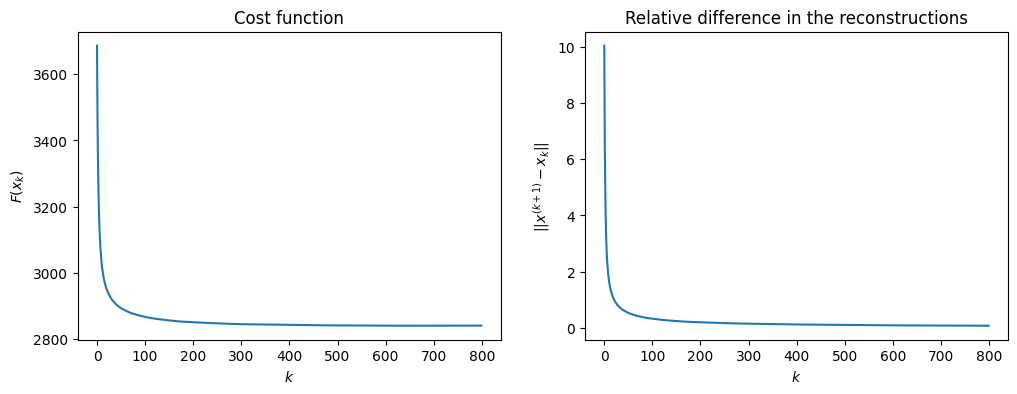

\lambda=0.7
Iter 100/800
Iter 200/800
Iter 300/800
Iter 400/800
Iter 500/800
Iter 600/800
Iter 700/800
Iter 800/800


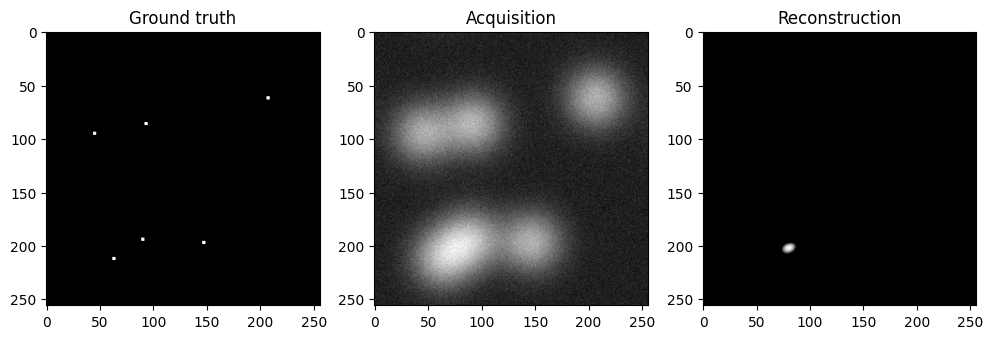

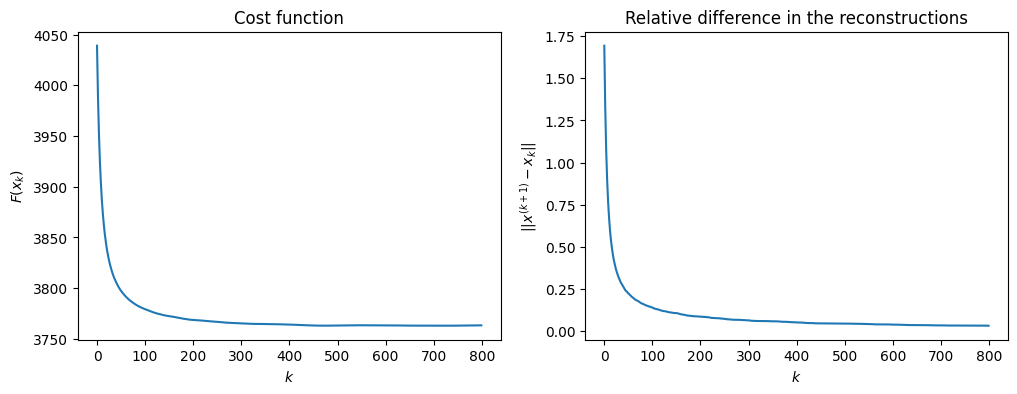

\lambda=1
Iter 100/800
Iter 200/800
Iter 300/800
Iter 400/800
Iter 500/800
Iter 600/800
Iter 700/800
Iter 800/800


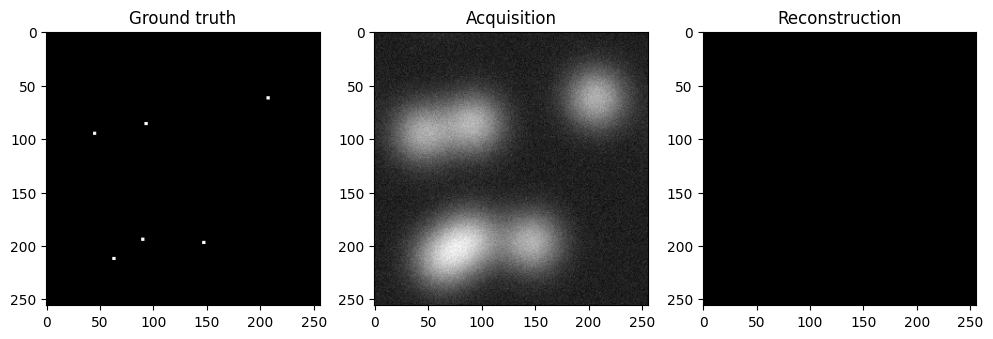

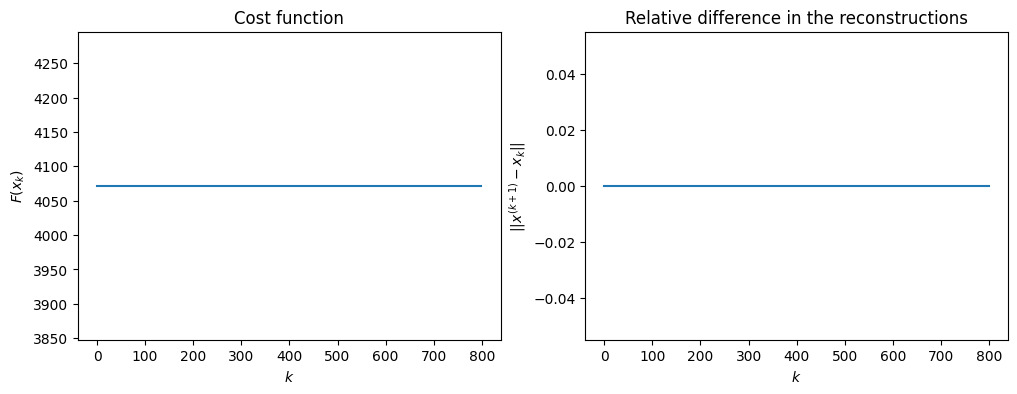

In [17]:
dim = (n, n)
x0 = np.zeros(dim)
tau = 1
maxiter = 800
epsilon = 0

# choose some values for lmbda
lmbda = [0.001, 0.1, 0.2, 0.5, 0.7, 1]

# compute the reconstruction
for l in lmbda:
  print("\lambda=" + str(l))
  rec, cost, norms = FB(x0, tau, l, acq, h, epsilon, maxiter)
  plot_results(rec, cost, norms)


The choice of $\lambda$ affects heavily the reconstruction: small $\lambda$ implies very little regularisation, so little that the reconstructed image is nowhere near the ground truth. Similarly, large $\lambda$ implies 'too much' regularisation in which case the reconstructed image is the zero image. One should choose a regularisation parameter which is not too low (a lot of blurring in the reconstruction) and not too big (reconstruction with missing information, i.e. non reconstructed molecules). Choosing the best parameter is generally a tedious task and is usually done using grid-search techniques.

N.B. A parameter that is good for one image might be too small or too big for another. Each case has to be treated independently.


2. For example try $\lambda=0$. What happens? Which algorithm are you actually using in this very particular case? (Look both at the reconstructed image and at the equation defining the model with $\lambda=0$)


Iter 100/800
Iter 200/800
Iter 300/800
Iter 400/800
Iter 500/800
Iter 600/800
Iter 700/800
Iter 800/800


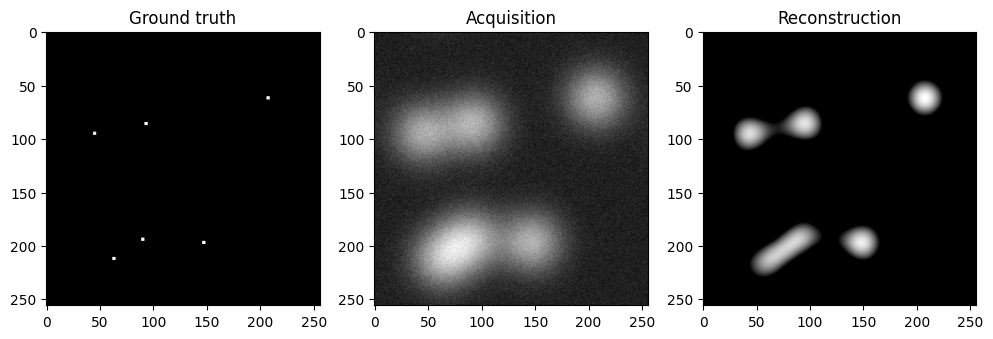

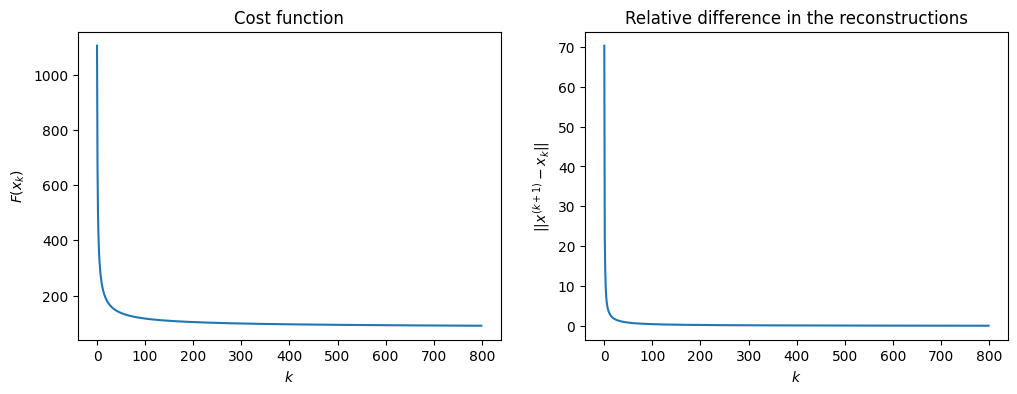

In [18]:
rec, cost, norms = FB(x0, tau, 0, acq, h, epsilon, maxiter)
plot_results(rec, cost, norms)


With $\lambda=0$ we are not using any regularisation term, hence we obtain a very bad reconstruction, similar to the ones obtained above with a very small $\lambda$.

The optimisation problem
$$ \operatorname{argmin}_{x\in\mathbb R^n} \frac{1}{2}\|Ax-y\|\_2^2+\lambda \|x\|\_1+\texttt{i}_{\ge 0}(x) \qquad (1)$$
with $\lambda=0$ becomes 
$$ \operatorname{argmin}_{x\in\mathbb R^n} \frac{1}{2}\|Ax-y\|\_2^2+\texttt{i}_{\ge 0}(x) \qquad (2).$$
We solve (1) with ISTA algorithm, which has three fundamental steps: gradient descent for the fidelity term, proximal step for the penalty, projection onto the positive axes. 
Using the same scheme for (2), the proximal step for the penalty disappears because $\lambda=0$ but we still perform the gradient step and the projection onto the positive axes.

The algorithm used in this particular case is PROJECTED GRADIENT DESCENT.


## Questions: step-size

To answer the following questions set $\lambda=0.3$, $maxiter = 1000$, $\epsilon = 0$ and $x_0=0$.

3. Try a very small stepsize and have a look at how the cost function is decreasing.


Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


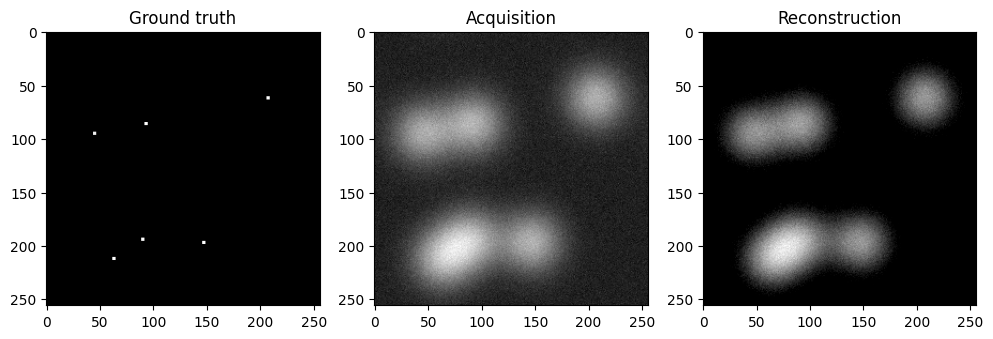

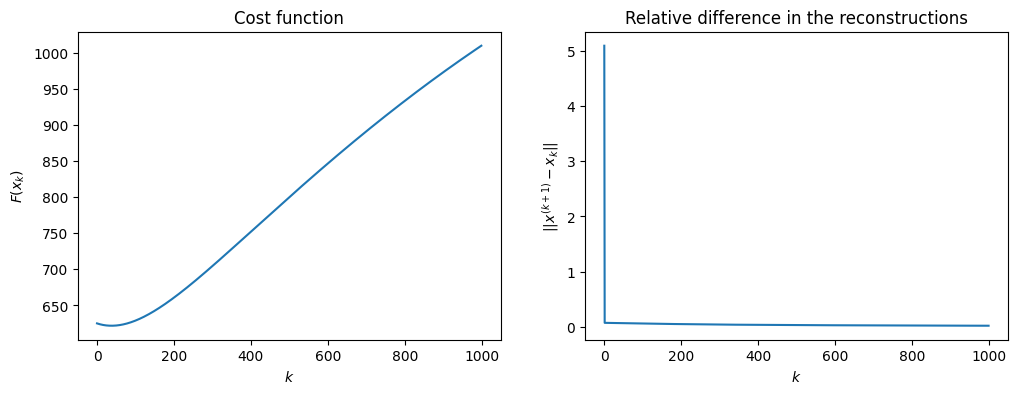

In [19]:
dim = (n, n)
# x0 = np.zeros(dim)
x0 = acq
tau = 0.001
maxiter = 1000
epsilon = 0
lmbda = 0.3

rec, cost, norms = FB(x0, tau, lmbda, acq, h, epsilon, maxiter)
plot_results(rec, cost, norms)


4. Then try $\tau=\frac{1}{Lips}$. What do you observe?


Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


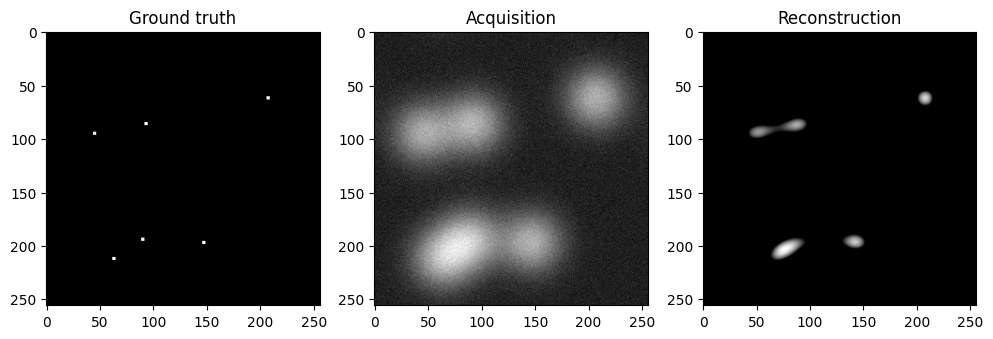

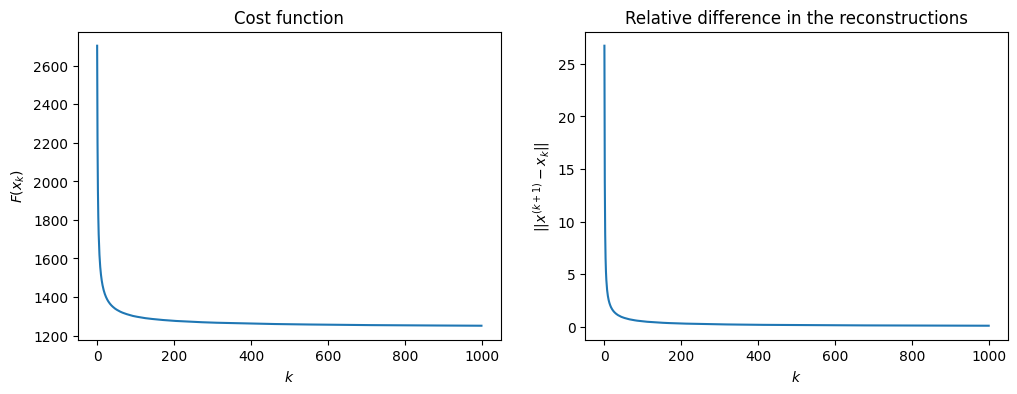

In [20]:
dim = (n, n)
x0 = np.zeros(dim)
tau = 1 / Lips
maxiter = 1000
epsilon = 0
lmbda = 0.3

rec, cost, norms = FB(x0, tau, lmbda, acq, h, epsilon, maxiter)
plot_results(rec, cost, norms)


5. Then try $\tau>>\frac{1}{Lips}$. What do you observe?

(Hint: plot the cost functions in the three cases)


Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


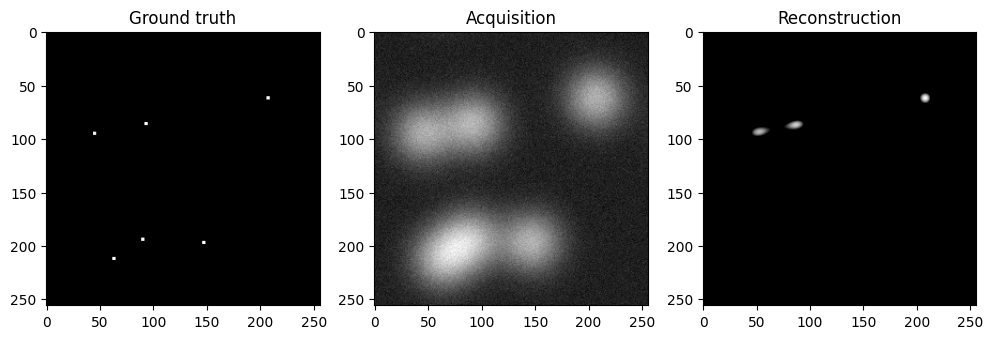

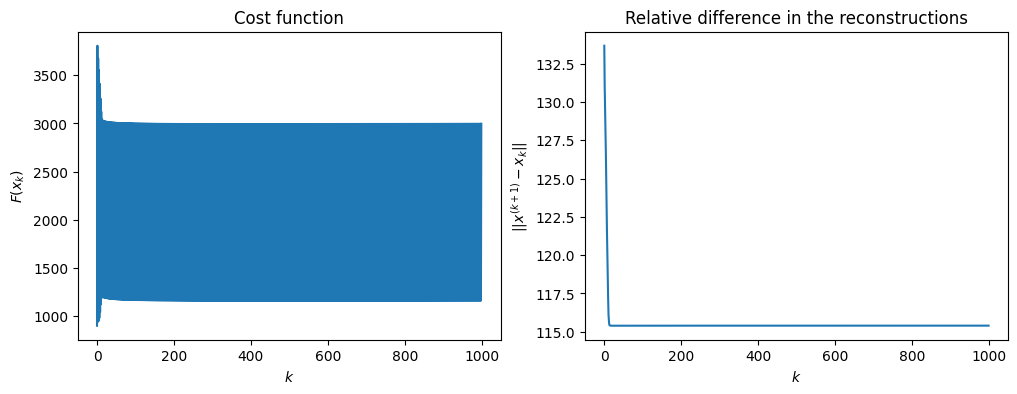

In [21]:
dim = (n, n)
x0 = np.zeros(dim)
tau = 5
maxiter = 1000
epsilon = 0
lmbda = 0.3

rec, cost, norms = FB(x0, tau, lmbda, acq, h, epsilon, maxiter)
plot_results(rec, cost, norms)


The convergence speed with a very small stepsize $\tau$ is very slow and consequently the reconstruction is still very blurred after 1000 iterations. We can reach convergence and a good reconstruction but we need a higher number of iterations.

The choice of $\tau=1/Lips$ is optimal: the convergence speed is way faster than what observed before and we could stop even before 1000 iterations since in the late iterations the cost doesn't decraese much.

With $\tau>>1/Lips$, the cost function is not decreasing but oscillates. The stepsize is too big and at each iteration the algorithm "jumps" from side to side of the convex function, without being able to reach the minimum.

Recall that we have convergence guarantees for $\tau\in(0,1/Lips]$.


## Questions: Fast Iterative Soft Thresholding Algorithm


6. Starting from the function for the FB algorithm defined above, write a code for the Fast Iterative Soft Thresholding Algorithm (FISTA).


In [22]:
def FISTA(x0, tau, lmbda, y, h, epsilon, maxiter):
  xk = x0
  xold = x0
  yk = x0
  told = 1
  cost = np.zeros(maxiter)
  norms = np.zeros(maxiter)
  for k in np.arange(maxiter):
    # update tk
    tk = 0.5 * (1 + math.sqrt(1 + 4 * told**2))
    # inertia step
    yk = xk + (told - 1) / tk * (xk - xold)
    # forward step: gradient descent of f
    z = yk - tau * gradient(yk, h, y)
    # backward step
    z = soft_thresholding(z, tau * lmbda)
    # positivity constraints
    z = np.maximum(0, z)
    # store the old iterations
    told = tk
    xold = xk
    xk = z
    # compute the cost function
    cost[k] = cost_function(xk, h, y, lmbda)
    norms[k] = np.linalg.norm(xk - xold)
    if np.abs(cost[k] - cost[k - 1]) / cost[k] < epsilon:
      break
  return xk, cost, norms


Check that your algorithm is working by computing the reconstruction for the following set of input parameters.


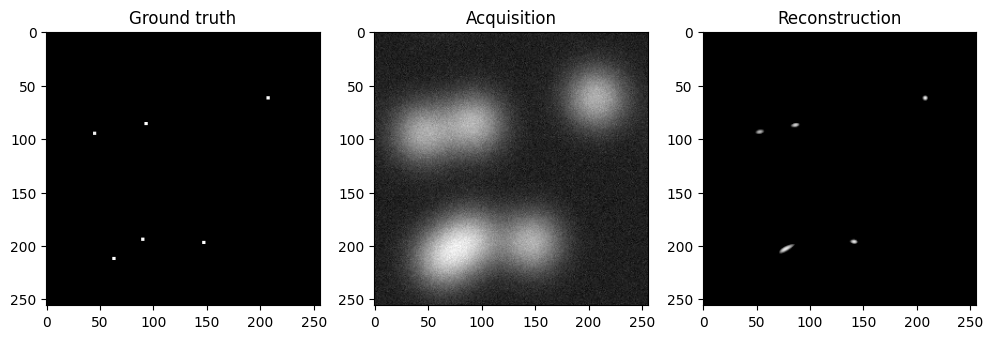

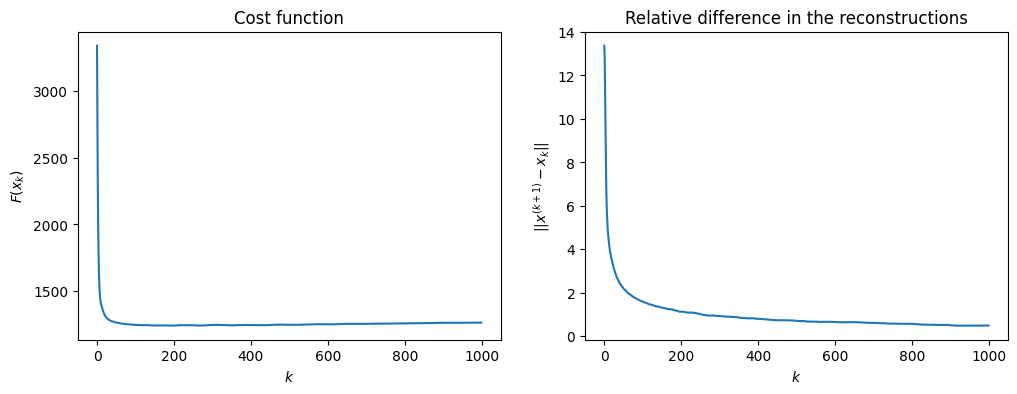

In [23]:
dim = (n, n)
x0 = np.zeros(dim)
tau = 0.5
lmbda = 0.3
maxiter = 1000
epsilon = 0.001

# compute the reconstruction
recFISTA, costFISTA, normsFISTA = FISTA(x0, tau, lmbda, acq, h, 0, maxiter)
plot_results(recFISTA, costFISTA, normsFISTA)


7. Compared to the reconstruction with the ISTA or FB algorithm, how does the cost function decrease? Set $\lambda=0.3$, $\tau=\frac{1}{Lips}$, $maxiter = 1000$, $\epsilon = 0$ and $x_0=0$ in both cases.

---

We see that in about 100 iterations, FISTA has already converged to a good reconstruction, while FB requires about 1000 iterations to reach the same level of quality.

Now, about the qualitative analysis of the reconstructions, we can see that the FISTA reconstruction is sharper than the FB one. The blur effect is less visible in the FISTA reconstruction.

---


Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


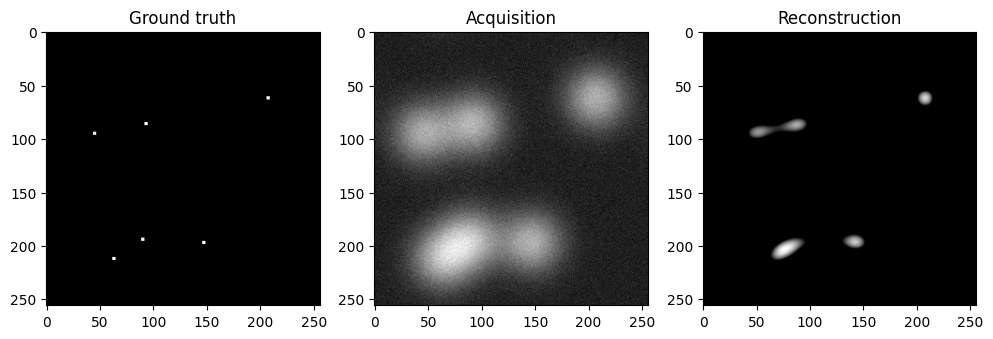

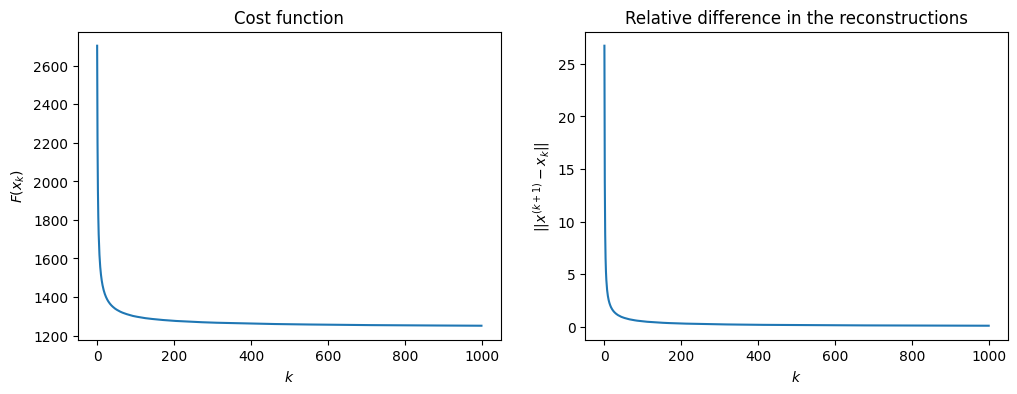

In [26]:
lmbda = 0.3
tau = 1 / Lips
maxiter = 1000
epsilon = 0.0
dim = (n, n)
x0 = np.zeros(dim)

# compute the reconstruction
rec, cost, norms = FB(x0, tau, lmbda, acq, h, epsilon, maxiter)
plot_results(rec, cost, norms)


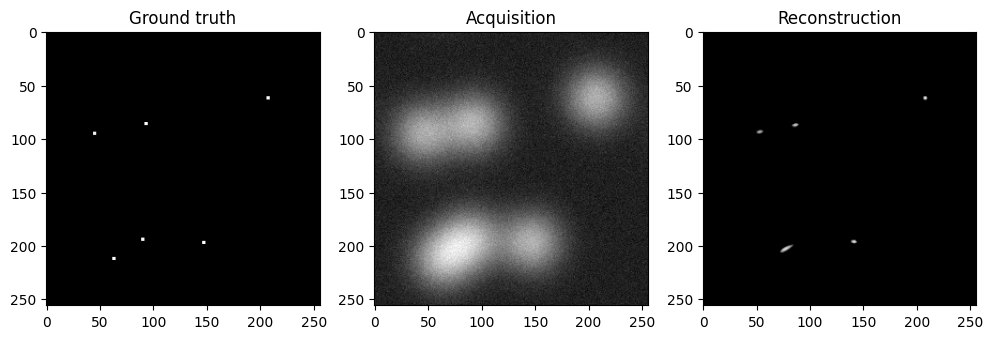

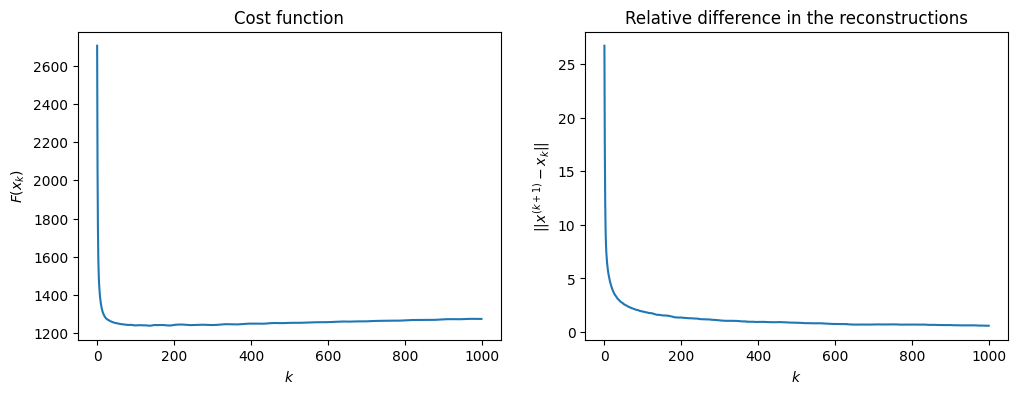

In [27]:

# compute the reconstruction
recFISTA, costFISTA, normsFISTA = FISTA(x0, tau, lmbda, acq, h, epsilon, maxiter)
plot_results(recFISTA, costFISTA, normsFISTA)


You should obtain similar reconstructions of good quality. With ISTA we need 1000 iterations. With FISTA we need only about 100.
